### Zigbang 원룸 매물 데이터 수집

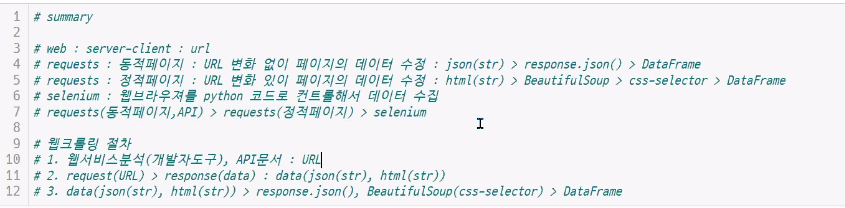

- request 할 때 401, 403, 500 등등의 에러가 발생하는 경우 > headers 수정해서 데이터 요청(user-agent, refere)
- API 이용 : request token 수집후 크롤링

#### Process
    - 동이름으로 위도 경도 구하기
    - 위도 경도로 geohash 알아내기
    - geohash로 매물 아이디 가져오기
    - 매물 아이디로 매물 정보 가져오기

#### 1. 동이름으로 위도 경도 구하기

In [1]:
import pandas as pd
import requests

In [ ]:
deposit_gteq : 0 -> 보증금 0원 변수를 보고 어떤 url인지 예측 가능
geohash : 지리정보 알려주는 hash 코드

In [7]:
#1. URL
address = "개포동"
url = f"https://apis.zigbang.com/v2/search?leaseYn=N&q={address}&serviceType=원룸"

#2. request > response : json(str)
response = requests.get(url)
data = response.json()["items"][0]
lat, lng = data["lat"], data["lng"]
lat, lng
#3. json(str) > lat, lng

(37.48192596435547, 127.05744171142578)

#### 2. 위도 경도로 geohash 알아내기

In [14]:
import geohash2
#precision : 클수록 영역이 작아짐
geohash = geohash2.encode(lat, lng, precision = 5)
geohash

'wydm5'

#### 3. geohash로 매물 아이디 가져오기

In [19]:
url = f"https://apis.zigbang.com/v2/items?deposit_gteq=0&domain=zigbang&geohash={geohash}&needHasNoFiltered=true&\
rent_gteq=0&sales_type_in=전세|월세&service_type_eq=원룸"
response = requests.get(url)
response

<Response [200]>

In [22]:
data = response.json()["items"]
ids = [item["item_id"] for item in data]
len(ids), ids[:5]

(107, [34927034, 35426451, 35455801, 35063089, 35451237])

#### 4. 매물 아이디로 매물 정보 가져오기

In [23]:
# name(list) -> network -> payload
url = "https://apis.zigbang.com/v2/items/list"
params = {
    "domain" : "zigbang",
    "withCoalition" : "true",
    "item_ids" : ids[:900] #아이템 데이터의 갯수를 999개까지 사용 가능 
}
response = requests.post(url, params) #인코딩 필요없어서 dumps 필요없다
response

<Response [200]>

In [24]:
#매물 데이터를 DF로 만든다
data = response.json()["items"]
df = pd.DataFrame(data)
df.tail(2)

,section_type,item_id,images_thumbnail,sales_type,sales_title,deposit,rent,size_m2,공급면적,전용면적,...,status,service_type,tags,address1,address2,address3,manage_cost,reg_date,is_new,contract
105,None,35132645,https://ic.zigbang.com/ic/items/35132645/1.jpg,전세,전세,20000,0,59.22,"{'m2': 59.22, 'p': '17.9'}","{'m2': 47.37, 'p': '14.3'}",...,True,빌라,[],서울시 강남구 개포동,None,None,5,2023-02-14T15:05:43+09:00,False,
106,None,35421064,https://ic.zigbang.com/ic/items/35421064/1.jpg,전세,전세,32000,0,35.48,"{'m2': 35.48, 'p': '10.7'}","{'m2': 27.72, 'p': '8.4'}",...,True,빌라,[추천],서울시 강남구 개포동,None,None,6,2023-02-14T12:15:02+09:00,False,


In [26]:
df.columns

Index(['section_type', 'item_id', 'images_thumbnail', 'sales_type',
       'sales_title', 'deposit', 'rent', 'size_m2', '공급면적', '전용면적', '계약면적',
       'room_type_title', 'floor', 'floor_string', 'building_floor', 'title',
       'is_first_movein', 'room_type', 'address', 'random_location', 'is_zzim',
       'status', 'service_type', 'tags', 'address1', 'address2', 'address3',
       'manage_cost', 'reg_date', 'is_new', 'contract'],
      dtype='object')

In [29]:
colums = ['item_id', 'sales_type', 'deposit', 'rent', 'size_m2', 'floor', 'building_floor', 'title',
       'address', 'status', 'service_type', 'tags', 'address1', 'manage_cost']
df = df[colums]
df = df[df["address"].str.contains(address)].reset_index(drop = True)
df.tail(2)

,item_id,sales_type,deposit,rent,size_m2,floor,building_floor,title,address,status,service_type,tags,address1,manage_cost
64,35132645,전세,20000,0,59.22,2,5,💥계약임박💥넓게빠진집💥조용한동네💖,강남구 개포동,True,빌라,[],서울시 강남구 개포동,5
65,35421064,전세,32000,0,35.48,3,4,💜신혼강추💛풀옵션🧡조용한2룸💚신축 첫입주💜,강남구 개포동,True,빌라,[추천],서울시 강남구 개포동,6


In [30]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
